Main notebook file

In [1]:
pip install meteostat

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U dataretrieval

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import modules
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import glob
import datetime as dt

import numpy as np
import rasterio
import xarray as xr

import folium

import dataretrieval.nwis as nwis

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Read in paradise climate data from [USDA Snotel](https://wcc.sc.egov.usda.gov/reportGenerator/view/customMultiTimeSeriesGroupByStationReport/daily/start_of_period/679:WA:SNTL%7Cid=%22%22%7Cname/2012-01-01,2022-02-22/PREC::value,PRCPMTD::value,TAVG::value,TMIN::value,TMAX::value,SMS:-2:value,SMS:-4:value,SMS:-8:value,SMS:-20:value,SNDN::value,WTEQ::value,SNWD::value,SNRR::value?fitToScreen=false)

In [3]:
paradise_path = '/Users/ivanduse/Dropbox (University of Oregon)/gage-guesser/data/paradiseclimate.csv'

In [4]:
pclim = pd.read_csv(paradise_path)
pclim['Date'] = pd.to_datetime(pclim['Date'])
pclim = pclim.set_index(['Date'])
pclim = pclim.loc['2012-01-01':'2021-12-31']
pclim

,Paradise (679) Precipitation Accumulation (in) Start of Day Values,Paradise (679) Precipitation Increment (in),Paradise (679) Precipitation Increment - Snow-adj (in),Paradise (679) Air Temperature Average (degF),Paradise (679) Air Temperature Minimum (degF),Paradise (679) Air Temperature Maximum (degF),Paradise (679) Soil Moisture Percent -2in (pct) Start of Day Values,Paradise (679) Soil Moisture Percent -4in (pct) Start of Day Values,Paradise (679) Soil Moisture Percent -8in (pct) Start of Day Values,Paradise (679) Soil Moisture Percent -20in (pct) Start of Day Values,Paradise (679) Snow Density (pct) Start of Day Values,Paradise (679) Snow Water Equivalent (in) Start of Day Values,Paradise (679) Snow Depth (in) Start of Day Values,Paradise (679) Snow Rain Ratio (unitless),Paradise (679) Real Dielectric Constant -2in (unitless) Start of Day Values
Date,,,,,,,,,,,,,,,
2012-01-01,33.8,0.8,0.8,35.0,29.0,45.0,32.7,32.3,37.8,36.6,42.8,24.4,57.0,38.0,NaN
2012-01-02,34.6,0.2,0.6,37.0,31.0,47.0,32.2,32.0,37.6,36.5,41.9,24.7,59.0,300.0,NaN
2012-01-03,34.8,0.1,0.1,35.0,31.0,42.0,32.0,31.9,37.4,36.3,42.2,25.3,60.0,100.0,NaN
2012-01-04,34.9,0.7,1.0,39.0,31.0,45.0,31.7,31.5,37.4,36.3,43.1,25.4,59.0,143.0,NaN
2012-01-05,35.6,0.1,0.1,26.0,19.0,32.0,31.7,31.8,37.5,36.3,44.0,26.4,60.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,60.4,0.2,0.2,11.0,5.0,16.0,20.2,22.6,33.8,34.1,23.9,24.9,104.0,0.0,NaN
2021-12-28,60.6,0.3,0.3,17.0,13.0,21.0,20.1,22.6,33.8,34.1,24.2,24.9,103.0,67.0,NaN
2021-12-29,60.9,0.1,0.1,17.0,13.0,22.0,20.2,22.5,33.8,34.1,24.9,25.1,101.0,100.0,NaN


In [5]:
pclim['Surface Soil Moisture'] = pclim['Paradise (679) Soil Moisture Percent -2in (pct) Start of Day Values']
pclim['Depth Soil Moisture'] = (
                          pclim['Paradise (679) Soil Moisture Percent -4in (pct) Start of Day Values']+\
                          pclim['Paradise (679) Soil Moisture Percent -8in (pct) Start of Day Values']+\
                          pclim['Paradise (679) Soil Moisture Percent -20in (pct) Start of Day Values'])/4
df = pclim.drop(['Paradise (679) Soil Moisture Percent -2in (pct) Start of Day Values',\
                'Paradise (679) Soil Moisture Percent -4in (pct) Start of Day Values',\
                'Paradise (679) Soil Moisture Percent -8in (pct) Start of Day Values',\
                'Paradise (679) Soil Moisture Percent -20in (pct) Start of Day Values',\
                'Paradise (679) Real Dielectric Constant -2in (unitless) Start of Day Values'], axis=1)
df

,Paradise (679) Precipitation Accumulation (in) Start of Day Values,Paradise (679) Precipitation Increment (in),Paradise (679) Precipitation Increment - Snow-adj (in),Paradise (679) Air Temperature Average (degF),Paradise (679) Air Temperature Minimum (degF),Paradise (679) Air Temperature Maximum (degF),Paradise (679) Snow Density (pct) Start of Day Values,Paradise (679) Snow Water Equivalent (in) Start of Day Values,Paradise (679) Snow Depth (in) Start of Day Values,Paradise (679) Snow Rain Ratio (unitless),Surface Soil Moisture,Depth Soil Moisture
Date,,,,,,,,,,,,
2012-01-01,33.8,0.8,0.8,35.0,29.0,45.0,42.8,24.4,57.0,38.0,32.7,26.675
2012-01-02,34.6,0.2,0.6,37.0,31.0,47.0,41.9,24.7,59.0,300.0,32.2,26.525
2012-01-03,34.8,0.1,0.1,35.0,31.0,42.0,42.2,25.3,60.0,100.0,32.0,26.400
2012-01-04,34.9,0.7,1.0,39.0,31.0,45.0,43.1,25.4,59.0,143.0,31.7,26.300
2012-01-05,35.6,0.1,0.1,26.0,19.0,32.0,44.0,26.4,60.0,0.0,31.7,26.400
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,60.4,0.2,0.2,11.0,5.0,16.0,23.9,24.9,104.0,0.0,20.2,22.625
2021-12-28,60.6,0.3,0.3,17.0,13.0,21.0,24.2,24.9,103.0,67.0,20.1,22.625
2021-12-29,60.9,0.1,0.1,17.0,13.0,22.0,24.9,25.1,101.0,100.0,20.2,22.600


## Read in Discharge Data

In [6]:
# specify the USGS site code for which we want data.
nisqually = '12082500' #nisqually river
puyallup = '12092000' #puyallup basin
cowlitz = '14226500' #cowlitz basin


# get instantaneous values (iv)
nisDis = nwis.get_record(sites=nisqually, service='dv', start='2012-01-01', end='2021-12-31')
nisDis

,00020_Maximum,00020_Maximum_cd,site_no,00020_Minimum,00020_Minimum_cd,00020_Mean,00020_Mean_cd,00060_Mean,00060_Mean_cd,00065_Mean,00065_Mean_cd
datetime,,,,,,,,,,,
2012-01-01 00:00:00+00:00,NaN,NaN,12082500,NaN,NaN,NaN,NaN,1220.0,A,6.41,A
2012-01-02 00:00:00+00:00,NaN,NaN,12082500,NaN,NaN,NaN,NaN,1010.0,A,6.10,A
2012-01-03 00:00:00+00:00,NaN,NaN,12082500,NaN,NaN,NaN,NaN,900.0,A,5.92,A
2012-01-04 00:00:00+00:00,NaN,NaN,12082500,NaN,NaN,NaN,NaN,844.0,A,5.82,A
2012-01-05 00:00:00+00:00,NaN,NaN,12082500,NaN,NaN,NaN,NaN,1010.0,A,6.09,A
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27 00:00:00+00:00,-5.3,P,12082500,-8.6,P,-6.7,P,656.0,P,4.92,P
2021-12-28 00:00:00+00:00,-1.4,P,12082500,-5.6,P,-3.5,P,610.0,P,4.85,P
2021-12-29 00:00:00+00:00,-3.4,P,12082500,-5.7,P,-4.7,P,567.0,P,4.78,P


### Combine data frames

In [7]:
df['Nisqually Discharge'] = nisDis['00060_Mean'].values
df

,Paradise (679) Precipitation Accumulation (in) Start of Day Values,Paradise (679) Precipitation Increment (in),Paradise (679) Precipitation Increment - Snow-adj (in),Paradise (679) Air Temperature Average (degF),Paradise (679) Air Temperature Minimum (degF),Paradise (679) Air Temperature Maximum (degF),Paradise (679) Snow Density (pct) Start of Day Values,Paradise (679) Snow Water Equivalent (in) Start of Day Values,Paradise (679) Snow Depth (in) Start of Day Values,Paradise (679) Snow Rain Ratio (unitless),Surface Soil Moisture,Depth Soil Moisture,Nisqually Discharge
Date,,,,,,,,,,,,,
2012-01-01,33.8,0.8,0.8,35.0,29.0,45.0,42.8,24.4,57.0,38.0,32.7,26.675,1220.0
2012-01-02,34.6,0.2,0.6,37.0,31.0,47.0,41.9,24.7,59.0,300.0,32.2,26.525,1010.0
2012-01-03,34.8,0.1,0.1,35.0,31.0,42.0,42.2,25.3,60.0,100.0,32.0,26.400,900.0
2012-01-04,34.9,0.7,1.0,39.0,31.0,45.0,43.1,25.4,59.0,143.0,31.7,26.300,844.0
2012-01-05,35.6,0.1,0.1,26.0,19.0,32.0,44.0,26.4,60.0,0.0,31.7,26.400,1010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,60.4,0.2,0.2,11.0,5.0,16.0,23.9,24.9,104.0,0.0,20.2,22.625,656.0
2021-12-28,60.6,0.3,0.3,17.0,13.0,21.0,24.2,24.9,103.0,67.0,20.1,22.625,610.0
2021-12-29,60.9,0.1,0.1,17.0,13.0,22.0,24.9,25.1,101.0,100.0,20.2,22.600,567.0


In [8]:
#drop the NAN values
df.dropna(inplace=True)

# Create the most basic of all machine learning models

In [9]:
# Define feature list
feature_list =  df.columns.to_list()



In [10]:
# Compute correlation matrix
corr_matrix = df.corr()

# Display just house value correlations
corr_matrix["Nisqually Discharge"].sort_values(ascending= False)

Nisqually Discharge                                                   1.000000
Depth Soil Moisture                                                   0.328579
Paradise (679) Precipitation Increment (in)                           0.315992
Paradise (679) Precipitation Increment - Snow-adj (in)                0.288026
Surface Soil Moisture                                                 0.193507
Paradise (679) Air Temperature Minimum (degF)                         0.180381
Paradise (679) Air Temperature Average (degF)                         0.174041
Paradise (679) Air Temperature Maximum (degF)                         0.110131
Paradise (679) Snow Density (pct) Start of Day Values                 0.063864
Paradise (679) Precipitation Accumulation (in) Start of Day Values    0.001163
Paradise (679) Snow Water Equivalent (in) Start of Day Values         0.000028
Paradise (679) Snow Depth (in) Start of Day Values                   -0.036676
Paradise (679) Snow Rain Ratio (unitless)           

In [11]:

# Define features and labels 
X = df[feature_list]
y = df['Nisqually Discharge']

# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)

In [12]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.ensemble import RandomForestRegressor

# Define model
forest_reg = RandomForestRegressor(n_estimators = 100)

# Fit model
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [14]:

# Predict test labels predictions
predictions = forest_reg.predict(X_test)

# Compute mean-squared-error
final_mse = mean_squared_error(y_test , predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

220.00959108928126

In [15]:
df['Nisqually Discharge'].max()

9920.0

(0.0, 10000.0)

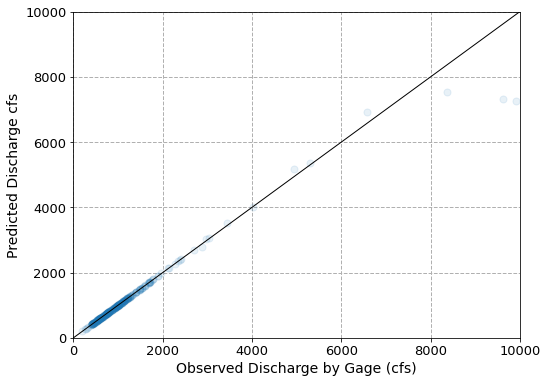

In [16]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test, predictions, alpha=0.1, s=50, zorder=2)
ax.plot([0,10000], [0, 10000], color='k', lw=1, zorder=3)
ax.set_ylabel('Predicted Discharge cfs', fontsize=14)
ax.set_xlabel('Observed Discharge by Gage (cfs)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(ls='dashed', lw=1, zorder=1)
ax.set_ylim(0,10000)
ax.set_xlim(0,10000)

### SICK MAP

In [18]:
nisqually_loc = 46.75260766, -122.0837194
paradise_loc = 46.78, -121.75
Modis_loc = 46.783, -121.73
 

#### add in shapefile of the upstream basin and a centerline of our river...
[like this](https://waterdata.usgs.gov/monitoring-location/12082500/#parameterCode=00065&period=P7D)

In [19]:
fmap = folium.Map(location=[nisqually_loc[0],nisqually_loc[1]], zoom_start=9)
folium.Marker(nisqually_loc, popup='Nisqually Gage').add_to(fmap)
folium.Marker(paradise_loc, popup='Paradise Snotel').add_to(fmap)
folium.Marker(Modis_loc, popup='MODIS').add_to(fmap)
fmap

# PART 3 - MODIS thru GITHUB

In [13]:
#imports some repeated
import requests
import json
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


url = "https://modis.ornl.gov/rst/api/v1/"
header = {'Accept': 'application/json'} # Use following for a csv response: header = {'Accept': 'text/csv'}

# Build time series from daymet pulls from Github


In [24]:
daymet_bands = ['prcp', 'swe','tmax','tmin']
start_dates = ['A2013001', 'A2014001', 'A2015001', 'A2016001', 'A2017001', 'A2018001']
end_dates = ['A2014001', 'A2015001', 'A2016001', 'A2017001', 'A2018001', 'A2019001']

In [25]:
response = requests.get('https://modis.ornl.gov/rst/api/v1/Daymet/us_washington_paradise_mount_rainier_national_park/dates')
dates = json.loads(response.text)['dates']

modis_dates = [i['modis_date'] for i in dates]
calendar_dates = [i['calendar_date'] for i in dates]

### Gathering precipitation data

In [26]:
prcp_df = []

for i in range(len(start_dates)):
    start_date = start_dates[i]
    end_date = end_dates[i]
    dates = modis_dates[modis_dates.index(start_date):modis_dates.index(end_date)]
    
    response = requests.get(f'https://modis.ornl.gov/rst/api/v1/Daymet/us_washington_paradise_mount_rainier_national_park/subset?band=prcp&startDate={start_date}&endDate={end_date}', headers=header)
    subset = json.loads(response.text)
    
    siteid = 'us_washington_paradise_mount_rainier_national_park'
    prod = 'Daymet' # MODIS product
    data_band = 'prcp' # Daytime LST band name
    qc_band = 'QC_Day' # Daytime QC band name
    above_below = 15 # km above/below
    left_right = 15 # km left/right
    
    # Initialize lists to store the returned LST and QC data
    lstdata = []
    qcdata = []

    # Iterate through the list of dates and submit subset requests for each date:
    for dt in dates:

        # Join LST request parameters to URL string and submit request
        lstresponse = requests.get("".join([
            url, prod, '/' , siteid, "/subset?",
            "band=", data_band,
            "&startDate=", dt,
            "&endDate=", dt,
        ]), headers=header)

        # Append subset data to lstdata
        lstdata.append( json.loads(lstresponse.text)['subset'][0]['data'] )

        # Join QC request parameters to URL string and submit request
        qcresponse = requests.get("".join([
            url, prod, '/',
            siteid, 
            "/subset?",
            "band=", data_band,
            "&startDate=", dt,
            "&endDate=", dt,
        ]), headers=header)


        # Append qc data to qcdata
        qcdata.append( json.loads(qcresponse.text)['subset'][0]['data'] )
        
             # Convert to real dates
    dates = [(datetime.datetime(int(date[1:5]), 1, 1) + datetime.timedelta(int(date[5:]))).strftime('%Y-%m-%d') for date in dates]

    lstdata = pd.DataFrame(lstdata, index=dates)
    qcdata = pd.DataFrame(qcdata, index=dates)
    
    qcvals = pd.unique(qcdata.values.ravel())
    
    # Create empty list to store QC bit information
    QC_Data = []

    # Iterate through the list of 8-bit integers and populate QC table with bit definitions 
    for integer in range(0, 256, 1):
        bits = list(map(int, list("{0:b}".format(integer).zfill(8))))

        # Describe each of the bits. Remember bits are big endian so bits[7] == bit 0
        # Mandatory_QA bits description
        if (bits[6] == 0 and bits[7] == 0):
            Mandatory_QA = 'LST GOOD'
        if (bits[6] == 0 and bits[7] == 1):
            Mandatory_QA = 'LST Produced,Other Quality'
        if (bits[6] == 1 and bits[7] == 0):
            Mandatory_QA = 'No Pixel,clouds'
        if (bits[6] == 1 and bits[7] == 1):
            Mandatory_QA = 'No Pixel, Other QA'

        # Data_Quality bits description
        if (bits[4] == 0 and bits[5] == 0):
            Data_Quality = 'Good Data'
        if (bits[4] == 0 and bits[5] == 1):
            Data_Quality = 'Other Quality'
        if (bits[4] == 1 and bits[5] == 0):
            Data_Quality = 'TBD'
        if (bits[4] == 1 and bits[5] == 1):
            Data_Quality = 'TBD'

        # Emiss_Err bits description
        if (bits[2] == 0 and bits[3] == 0):
            Emiss_Err = 'Emiss Err <= .01'
        if (bits[2] == 0 and bits[3] == 1):
            Emiss_Err = 'Emiss Err <= .02'
        if (bits[2] == 1 and bits[3] == 0):
            Emiss_Err = 'Emiss Err <= .04'
        if (bits[2] == 1 and bits[3] == 1):
            Emiss_Err = 'Emiss Err > .04'

        # LST_Err bits description
        if (bits[0] == 0 and bits[1] == 0):
            LST_Err = 'LST Err <= 1K'
        if (bits[0] == 0 and bits[1] == 1):
            LST_Err = 'LST Err <= 3K'
        if (bits[0] == 1 and bits[1] == 0):
            LST_Err = 'LST Err <= 2K'
        if (bits[0] == 1 and bits[1] == 1):
            LST_Err = 'LST Err > 3K' 

        # Append this integers bit values and descriptions to list
        QC_Data.append([integer] + bits + [Mandatory_QA, Data_Quality, Emiss_Err, LST_Err])


    # Convert QC bits and descriptions to pandas data frame
    QC_Data = pd.DataFrame(QC_Data, columns=['Integer_Value', 'Bit7', 'Bit6', 'Bit5', 'Bit4', 'Bit3', 'Bit2', 'Bit1', 'Bit0', 'Mandatory_QA', 'Data_Quality', 'Emiss_Err', 'LST_Err'])

    
    QC_Data = QC_Data.loc[QC_Data['Integer_Value'].isin(qcvals)]
    
    QC_Data = QC_Data.loc[QC_Data['Integer_Value'].isin([2,3]) | ((QC_Data['Bit0'] == 1) & (QC_Data['Bit1'] == 0) & (QC_Data['Bit6'] != 0))]
    
    filter = QC_Data['Integer_Value'].tolist()
    lstdata_filt = lstdata.mask(qcdata.isin(filter))

    scale = json.loads(response.text)['scale']
    lstdata_filt_scale = lstdata_filt*float(scale)

    ncol = int(json.loads(response.text)['ncols'])
    nrow = int(json.loads(response.text)['nrows'])


    lststats = pd.DataFrame(np.column_stack([lstdata_filt_scale.mean(axis=1), 
                                             lstdata_filt_scale.std(axis=1), 
                                             lstdata_filt_scale.apply(lambda row: (float(row.count())/(ncol*nrow))*100, axis=1)]), 
                            columns=['mean', 'sd', 'quality'], index=dates)

    # converting dataframe index to date time
    lststats.index = pd.to_datetime(lststats.index)
    
    prcp_df.append(lststats)
    print(prcp_df)
    


[                 mean        sd  quality
2013-01-02   0.000000  0.000000    100.0
2013-01-03   0.000000  0.000000    100.0
2013-01-04  11.757654  2.056706    100.0
2013-01-05   7.507901  1.637631    100.0
2013-01-06  11.034198  2.828179    100.0
...               ...       ...      ...
2013-12-28   0.000000  0.000000    100.0
2013-12-29   0.000000  0.000000    100.0
2013-12-30   0.000000  0.000000    100.0
2013-12-31   9.262963  1.398320    100.0
2014-01-01   3.844074  1.010385    100.0

[365 rows x 3 columns]]
[                 mean        sd  quality
2013-01-02   0.000000  0.000000    100.0
2013-01-03   0.000000  0.000000    100.0
2013-01-04  11.757654  2.056706    100.0
2013-01-05   7.507901  1.637631    100.0
2013-01-06  11.034198  2.828179    100.0
...               ...       ...      ...
2013-12-28   0.000000  0.000000    100.0
2013-12-29   0.000000  0.000000    100.0
2013-12-30   0.000000  0.000000    100.0
2013-12-31   9.262963  1.398320    100.0
2014-01-01   3.844074  1.01038

## SWE data

In [27]:
swe_df = []

for i in range(len(start_dates)):
    start_date = start_dates[i]
    end_date = end_dates[i]
    dates = modis_dates[modis_dates.index(start_date):modis_dates.index(end_date)]
    
    response = requests.get(f'https://modis.ornl.gov/rst/api/v1/Daymet/us_washington_paradise_mount_rainier_national_park/subset?band=prcp&startDate={start_date}&endDate={end_date}', headers=header)
    subset = json.loads(response.text)
    
    siteid = 'us_washington_paradise_mount_rainier_national_park'
    prod = 'Daymet' # MODIS product
    data_band = 'swe' # Daytime LST band name
    qc_band = 'QC_Day' # Daytime QC band name
    above_below = 15 # km above/below
    left_right = 15 # km left/right
    
    # Initialize lists to store the returned LST and QC data
    lstdata = []
    qcdata = []

    # Iterate through the list of dates and submit subset requests for each date:
    for dt in dates:

        # Join LST request parameters to URL string and submit request
        lstresponse = requests.get("".join([
            url, prod, '/' , siteid, "/subset?",
            "band=", data_band,
            "&startDate=", dt,
            "&endDate=", dt,
        ]), headers=header)

        # Append subset data to lstdata
        lstdata.append( json.loads(lstresponse.text)['subset'][0]['data'] )

        # Join QC request parameters to URL string and submit request
        qcresponse = requests.get("".join([
            url, prod, '/',
            siteid, 
            "/subset?",
            "band=", data_band,
            "&startDate=", dt,
            "&endDate=", dt,
        ]), headers=header)


        # Append qc data to qcdata
        qcdata.append( json.loads(qcresponse.text)['subset'][0]['data'] )
        
             # Convert to real dates
    dates = [(datetime.datetime(int(date[1:5]), 1, 1) + datetime.timedelta(int(date[5:]))).strftime('%Y-%m-%d') for date in dates]

    lstdata = pd.DataFrame(lstdata, index=dates)
    qcdata = pd.DataFrame(qcdata, index=dates)
    
    qcvals = pd.unique(qcdata.values.ravel())
    
    # Create empty list to store QC bit information
    QC_Data = []

    # Iterate through the list of 8-bit integers and populate QC table with bit definitions 
    for integer in range(0, 256, 1):
        bits = list(map(int, list("{0:b}".format(integer).zfill(8))))

        # Describe each of the bits. Remember bits are big endian so bits[7] == bit 0
        # Mandatory_QA bits description
        if (bits[6] == 0 and bits[7] == 0):
            Mandatory_QA = 'LST GOOD'
        if (bits[6] == 0 and bits[7] == 1):
            Mandatory_QA = 'LST Produced,Other Quality'
        if (bits[6] == 1 and bits[7] == 0):
            Mandatory_QA = 'No Pixel,clouds'
        if (bits[6] == 1 and bits[7] == 1):
            Mandatory_QA = 'No Pixel, Other QA'

        # Data_Quality bits description
        if (bits[4] == 0 and bits[5] == 0):
            Data_Quality = 'Good Data'
        if (bits[4] == 0 and bits[5] == 1):
            Data_Quality = 'Other Quality'
        if (bits[4] == 1 and bits[5] == 0):
            Data_Quality = 'TBD'
        if (bits[4] == 1 and bits[5] == 1):
            Data_Quality = 'TBD'

        # Emiss_Err bits description
        if (bits[2] == 0 and bits[3] == 0):
            Emiss_Err = 'Emiss Err <= .01'
        if (bits[2] == 0 and bits[3] == 1):
            Emiss_Err = 'Emiss Err <= .02'
        if (bits[2] == 1 and bits[3] == 0):
            Emiss_Err = 'Emiss Err <= .04'
        if (bits[2] == 1 and bits[3] == 1):
            Emiss_Err = 'Emiss Err > .04'

        # LST_Err bits description
        if (bits[0] == 0 and bits[1] == 0):
            LST_Err = 'LST Err <= 1K'
        if (bits[0] == 0 and bits[1] == 1):
            LST_Err = 'LST Err <= 3K'
        if (bits[0] == 1 and bits[1] == 0):
            LST_Err = 'LST Err <= 2K'
        if (bits[0] == 1 and bits[1] == 1):
            LST_Err = 'LST Err > 3K' 

        # Append this integers bit values and descriptions to list
        QC_Data.append([integer] + bits + [Mandatory_QA, Data_Quality, Emiss_Err, LST_Err])


    # Convert QC bits and descriptions to pandas data frame
    QC_Data = pd.DataFrame(QC_Data, columns=['Integer_Value', 'Bit7', 'Bit6', 'Bit5', 'Bit4', 'Bit3', 'Bit2', 'Bit1', 'Bit0', 'Mandatory_QA', 'Data_Quality', 'Emiss_Err', 'LST_Err'])

    
    QC_Data = QC_Data.loc[QC_Data['Integer_Value'].isin(qcvals)]
    
    QC_Data = QC_Data.loc[QC_Data['Integer_Value'].isin([2,3]) | ((QC_Data['Bit0'] == 1) & (QC_Data['Bit1'] == 0) & (QC_Data['Bit6'] != 0))]
    
    filter = QC_Data['Integer_Value'].tolist()
    lstdata_filt = lstdata.mask(qcdata.isin(filter))

    scale = json.loads(response.text)['scale']
    lstdata_filt_scale = lstdata_filt*float(scale)

    ncol = int(json.loads(response.text)['ncols'])
    nrow = int(json.loads(response.text)['nrows'])


    lststats = pd.DataFrame(np.column_stack([lstdata_filt_scale.mean(axis=1), 
                                             lstdata_filt_scale.std(axis=1), 
                                             lstdata_filt_scale.apply(lambda row: (float(row.count())/(ncol*nrow))*100, axis=1)]), 
                            columns=['mean', 'sd', 'quality'], index=dates)

        # converting dataframe index to date time
    lststats.index = pd.to_datetime(lststats.index)
    
    swe_df.append(lststats)
    print(swe_df)
    
    

[                  mean          sd  quality
2013-01-02   86.364815  138.751376    100.0
2013-01-03   85.462469  138.632399    100.0
2013-01-04   84.381481  138.513768    100.0
2013-01-05   82.577037  138.455101    100.0
2013-01-06   81.034321  138.536248    100.0
...                ...         ...      ...
2013-12-28  126.660617  283.013721    100.0
2013-12-29  125.917284  283.217375    100.0
2013-12-30  124.794815  283.440642    100.0
2013-12-31  122.421111  283.422549    100.0
2014-01-01  120.963580  283.730258    100.0

[365 rows x 3 columns]]
[                  mean          sd  quality
2013-01-02   86.364815  138.751376    100.0
2013-01-03   85.462469  138.632399    100.0
2013-01-04   84.381481  138.513768    100.0
2013-01-05   82.577037  138.455101    100.0
2013-01-06   81.034321  138.536248    100.0
...                ...         ...      ...
2013-12-28  126.660617  283.013721    100.0
2013-12-29  125.917284  283.217375    100.0
2013-12-30  124.794815  283.440642    100.0
2013-

[                  mean          sd  quality
2013-01-02   86.364815  138.751376    100.0
2013-01-03   85.462469  138.632399    100.0
2013-01-04   84.381481  138.513768    100.0
2013-01-05   82.577037  138.455101    100.0
2013-01-06   81.034321  138.536248    100.0
...                ...         ...      ...
2013-12-28  126.660617  283.013721    100.0
2013-12-29  125.917284  283.217375    100.0
2013-12-30  124.794815  283.440642    100.0
2013-12-31  122.421111  283.422549    100.0
2014-01-01  120.963580  283.730258    100.0

[365 rows x 3 columns],                   mean          sd  quality
2014-01-02   72.028889  191.361569    100.0
2014-01-03   69.945679  191.351377    100.0
2014-01-04   69.882593  191.373824    100.0
2014-01-05   69.881358  191.374277    100.0
2014-01-06   68.620123  191.213116    100.0
...                ...         ...      ...
2014-12-28  103.881358  378.364021    100.0
2014-12-29  109.066543  381.855546    100.0
2014-12-30  116.418889  381.629171    100.0
2014-1

## tmax data

In [28]:
tmax_df = []

for i in range(len(start_dates)):
    start_date = start_dates[i]
    end_date = end_dates[i]
    dates = modis_dates[modis_dates.index(start_date):modis_dates.index(end_date)]
    
    response = requests.get(f'https://modis.ornl.gov/rst/api/v1/Daymet/us_washington_paradise_mount_rainier_national_park/subset?band=prcp&startDate={start_date}&endDate={end_date}', headers=header)
    subset = json.loads(response.text)
    
    siteid = 'us_washington_paradise_mount_rainier_national_park'
    prod = 'Daymet' # MODIS product
    data_band = 'tmax' # Daytime LST band name
    qc_band = 'QC_Day' # Daytime QC band name
    above_below = 15 # km above/below
    left_right = 15 # km left/right
    
    # Initialize lists to store the returned LST and QC data
    lstdata = []
    qcdata = []

    # Iterate through the list of dates and submit subset requests for each date:
    for dt in dates:

        # Join LST request parameters to URL string and submit request
        lstresponse = requests.get("".join([
            url, prod, '/' , siteid, "/subset?",
            "band=", data_band,
            "&startDate=", dt,
            "&endDate=", dt,
        ]), headers=header)

        # Append subset data to lstdata
        lstdata.append( json.loads(lstresponse.text)['subset'][0]['data'] )

        # Join QC request parameters to URL string and submit request
        qcresponse = requests.get("".join([
            url, prod, '/',
            siteid, 
            "/subset?",
            "band=", data_band,
            "&startDate=", dt,
            "&endDate=", dt,
        ]), headers=header)


        # Append qc data to qcdata
        qcdata.append( json.loads(qcresponse.text)['subset'][0]['data'] )
        
             # Convert to real dates
    dates = [(datetime.datetime(int(date[1:5]), 1, 1) + datetime.timedelta(int(date[5:]))).strftime('%Y-%m-%d') for date in dates]

    lstdata = pd.DataFrame(lstdata, index=dates)
    qcdata = pd.DataFrame(qcdata, index=dates)
    
    qcvals = pd.unique(qcdata.values.ravel())
    
    # Create empty list to store QC bit information
    QC_Data = []

    # Iterate through the list of 8-bit integers and populate QC table with bit definitions 
    for integer in range(0, 256, 1):
        bits = list(map(int, list("{0:b}".format(integer).zfill(8))))

        # Describe each of the bits. Remember bits are big endian so bits[7] == bit 0
        # Mandatory_QA bits description
        if (bits[6] == 0 and bits[7] == 0):
            Mandatory_QA = 'LST GOOD'
        if (bits[6] == 0 and bits[7] == 1):
            Mandatory_QA = 'LST Produced,Other Quality'
        if (bits[6] == 1 and bits[7] == 0):
            Mandatory_QA = 'No Pixel,clouds'
        if (bits[6] == 1 and bits[7] == 1):
            Mandatory_QA = 'No Pixel, Other QA'

        # Data_Quality bits description
        if (bits[4] == 0 and bits[5] == 0):
            Data_Quality = 'Good Data'
        if (bits[4] == 0 and bits[5] == 1):
            Data_Quality = 'Other Quality'
        if (bits[4] == 1 and bits[5] == 0):
            Data_Quality = 'TBD'
        if (bits[4] == 1 and bits[5] == 1):
            Data_Quality = 'TBD'

        # Emiss_Err bits description
        if (bits[2] == 0 and bits[3] == 0):
            Emiss_Err = 'Emiss Err <= .01'
        if (bits[2] == 0 and bits[3] == 1):
            Emiss_Err = 'Emiss Err <= .02'
        if (bits[2] == 1 and bits[3] == 0):
            Emiss_Err = 'Emiss Err <= .04'
        if (bits[2] == 1 and bits[3] == 1):
            Emiss_Err = 'Emiss Err > .04'

        # LST_Err bits description
        if (bits[0] == 0 and bits[1] == 0):
            LST_Err = 'LST Err <= 1K'
        if (bits[0] == 0 and bits[1] == 1):
            LST_Err = 'LST Err <= 3K'
        if (bits[0] == 1 and bits[1] == 0):
            LST_Err = 'LST Err <= 2K'
        if (bits[0] == 1 and bits[1] == 1):
            LST_Err = 'LST Err > 3K' 

        # Append this integers bit values and descriptions to list
        QC_Data.append([integer] + bits + [Mandatory_QA, Data_Quality, Emiss_Err, LST_Err])


    # Convert QC bits and descriptions to pandas data frame
    QC_Data = pd.DataFrame(QC_Data, columns=['Integer_Value', 'Bit7', 'Bit6', 'Bit5', 'Bit4', 'Bit3', 'Bit2', 'Bit1', 'Bit0', 'Mandatory_QA', 'Data_Quality', 'Emiss_Err', 'LST_Err'])

    
    QC_Data = QC_Data.loc[QC_Data['Integer_Value'].isin(qcvals)]
    
    QC_Data = QC_Data.loc[QC_Data['Integer_Value'].isin([2,3]) | ((QC_Data['Bit0'] == 1) & (QC_Data['Bit1'] == 0) & (QC_Data['Bit6'] != 0))]
    
    filter = QC_Data['Integer_Value'].tolist()
    lstdata_filt = lstdata.mask(qcdata.isin(filter))

    scale = json.loads(response.text)['scale']
    lstdata_filt_scale = lstdata_filt*float(scale)

    ncol = int(json.loads(response.text)['ncols'])
    nrow = int(json.loads(response.text)['nrows'])


    lststats = pd.DataFrame(np.column_stack([lstdata_filt_scale.mean(axis=1), 
                                             lstdata_filt_scale.std(axis=1), 
                                             lstdata_filt_scale.apply(lambda row: (float(row.count())/(ncol*nrow))*100, axis=1)]), 
                            columns=['mean', 'sd', 'quality'], index=dates)

        # converting dataframe index to date time
    lststats.index = pd.to_datetime(lststats.index)
    
    tmax_df.append(lststats)
    print(tmax_df)
    


[                mean        sd  quality
2013-01-02 -6.503580  0.431217    100.0
2013-01-03 -3.813457  0.789635    100.0
2013-01-04 -3.379877  0.941267    100.0
2013-01-05 -1.602469  0.416063    100.0
2013-01-06 -2.218889  0.531058    100.0
...              ...       ...      ...
2013-12-28 -0.224938  0.353441    100.0
2013-12-29 -4.247160  1.535052    100.0
2013-12-30 -3.212593  0.951717    100.0
2013-12-31 -0.197407  0.088201    100.0
2014-01-01 -2.381358  1.275034    100.0

[365 rows x 3 columns]]
[                mean        sd  quality
2013-01-02 -6.503580  0.431217    100.0
2013-01-03 -3.813457  0.789635    100.0
2013-01-04 -3.379877  0.941267    100.0
2013-01-05 -1.602469  0.416063    100.0
2013-01-06 -2.218889  0.531058    100.0
...              ...       ...      ...
2013-12-28 -0.224938  0.353441    100.0
2013-12-29 -4.247160  1.535052    100.0
2013-12-30 -3.212593  0.951717    100.0
2013-12-31 -0.197407  0.088201    100.0
2014-01-01 -2.381358  1.275034    100.0

[365 rows x 

## tmin data

In [29]:
tmin_df = []

for i in range(len(start_dates)):
    start_date = start_dates[i]
    end_date = end_dates[i]
    dates = modis_dates[modis_dates.index(start_date):modis_dates.index(end_date)]
    
    response = requests.get(f'https://modis.ornl.gov/rst/api/v1/Daymet/us_washington_paradise_mount_rainier_national_park/subset?band=prcp&startDate={start_date}&endDate={end_date}', headers=header)
    subset = json.loads(response.text)
    
    siteid = 'us_washington_paradise_mount_rainier_national_park'
    prod = 'Daymet' # MODIS product
    data_band = 'tmin' # Daytime LST band name
    qc_band = 'QC_Day' # Daytime QC band name
    above_below = 15 # km above/below
    left_right = 15 # km left/right
    
    # Initialize lists to store the returned LST and QC data
    lstdata = []
    qcdata = []

    # Iterate through the list of dates and submit subset requests for each date:
    for dt in dates:

        # Join LST request parameters to URL string and submit request
        lstresponse = requests.get("".join([
            url, prod, '/' , siteid, "/subset?",
            "band=", data_band,
            "&startDate=", dt,
            "&endDate=", dt,
        ]), headers=header)

        # Append subset data to lstdata
        lstdata.append( json.loads(lstresponse.text)['subset'][0]['data'] )

        # Join QC request parameters to URL string and submit request
        qcresponse = requests.get("".join([
            url, prod, '/',
            siteid, 
            "/subset?",
            "band=", data_band,
            "&startDate=", dt,
            "&endDate=", dt,
        ]), headers=header)


        # Append qc data to qcdata
        qcdata.append( json.loads(qcresponse.text)['subset'][0]['data'] )
        
             # Convert to real dates
    dates = [(datetime.datetime(int(date[1:5]), 1, 1) + datetime.timedelta(int(date[5:]))).strftime('%Y-%m-%d') for date in dates]

    lstdata = pd.DataFrame(lstdata, index=dates)
    qcdata = pd.DataFrame(qcdata, index=dates)
    
    qcvals = pd.unique(qcdata.values.ravel())
    
    # Create empty list to store QC bit information
    QC_Data = []

    # Iterate through the list of 8-bit integers and populate QC table with bit definitions 
    for integer in range(0, 256, 1):
        bits = list(map(int, list("{0:b}".format(integer).zfill(8))))

        # Describe each of the bits. Remember bits are big endian so bits[7] == bit 0
        # Mandatory_QA bits description
        if (bits[6] == 0 and bits[7] == 0):
            Mandatory_QA = 'LST GOOD'
        if (bits[6] == 0 and bits[7] == 1):
            Mandatory_QA = 'LST Produced,Other Quality'
        if (bits[6] == 1 and bits[7] == 0):
            Mandatory_QA = 'No Pixel,clouds'
        if (bits[6] == 1 and bits[7] == 1):
            Mandatory_QA = 'No Pixel, Other QA'

        # Data_Quality bits description
        if (bits[4] == 0 and bits[5] == 0):
            Data_Quality = 'Good Data'
        if (bits[4] == 0 and bits[5] == 1):
            Data_Quality = 'Other Quality'
        if (bits[4] == 1 and bits[5] == 0):
            Data_Quality = 'TBD'
        if (bits[4] == 1 and bits[5] == 1):
            Data_Quality = 'TBD'

        # Emiss_Err bits description
        if (bits[2] == 0 and bits[3] == 0):
            Emiss_Err = 'Emiss Err <= .01'
        if (bits[2] == 0 and bits[3] == 1):
            Emiss_Err = 'Emiss Err <= .02'
        if (bits[2] == 1 and bits[3] == 0):
            Emiss_Err = 'Emiss Err <= .04'
        if (bits[2] == 1 and bits[3] == 1):
            Emiss_Err = 'Emiss Err > .04'

        # LST_Err bits description
        if (bits[0] == 0 and bits[1] == 0):
            LST_Err = 'LST Err <= 1K'
        if (bits[0] == 0 and bits[1] == 1):
            LST_Err = 'LST Err <= 3K'
        if (bits[0] == 1 and bits[1] == 0):
            LST_Err = 'LST Err <= 2K'
        if (bits[0] == 1 and bits[1] == 1):
            LST_Err = 'LST Err > 3K' 

        # Append this integers bit values and descriptions to list
        QC_Data.append([integer] + bits + [Mandatory_QA, Data_Quality, Emiss_Err, LST_Err])


    # Convert QC bits and descriptions to pandas data frame
    QC_Data = pd.DataFrame(QC_Data, columns=['Integer_Value', 'Bit7', 'Bit6', 'Bit5', 'Bit4', 'Bit3', 'Bit2', 'Bit1', 'Bit0', 'Mandatory_QA', 'Data_Quality', 'Emiss_Err', 'LST_Err'])

    
    QC_Data = QC_Data.loc[QC_Data['Integer_Value'].isin(qcvals)]
    
    QC_Data = QC_Data.loc[QC_Data['Integer_Value'].isin([2,3]) | ((QC_Data['Bit0'] == 1) & (QC_Data['Bit1'] == 0) & (QC_Data['Bit6'] != 0))]
    
    filter = QC_Data['Integer_Value'].tolist()
    lstdata_filt = lstdata.mask(qcdata.isin(filter))

    scale = json.loads(response.text)['scale']
    lstdata_filt_scale = lstdata_filt*float(scale)

    ncol = int(json.loads(response.text)['ncols'])
    nrow = int(json.loads(response.text)['nrows'])


    lststats = pd.DataFrame(np.column_stack([lstdata_filt_scale.mean(axis=1), 
                                             lstdata_filt_scale.std(axis=1), 
                                             lstdata_filt_scale.apply(lambda row: (float(row.count())/(ncol*nrow))*100, axis=1)]), 
                            columns=['mean', 'sd', 'quality'], index=dates)

        # converting dataframe index to date time
    lststats.index = pd.to_datetime(lststats.index)
    
    tmin_df.append(lststats)
    print(tmin_df)
    

[                  mean          sd  quality
2013-01-02   86.364815  138.751376    100.0
2013-01-03   85.462469  138.632399    100.0
2013-01-04   84.381481  138.513768    100.0
2013-01-05   82.577037  138.455101    100.0
2013-01-06   81.034321  138.536248    100.0
...                ...         ...      ...
2013-12-28  126.660617  283.013721    100.0
2013-12-29  125.917284  283.217375    100.0
2013-12-30  124.794815  283.440642    100.0
2013-12-31  122.421111  283.422549    100.0
2014-01-01  120.963580  283.730258    100.0

[365 rows x 3 columns]]
[                  mean          sd  quality
2013-01-02   86.364815  138.751376    100.0
2013-01-03   85.462469  138.632399    100.0
2013-01-04   84.381481  138.513768    100.0
2013-01-05   82.577037  138.455101    100.0
2013-01-06   81.034321  138.536248    100.0
...                ...         ...      ...
2013-12-28  126.660617  283.013721    100.0
2013-12-29  125.917284  283.217375    100.0
2013-12-30  124.794815  283.440642    100.0
2013-

[                  mean          sd  quality
2013-01-02   86.364815  138.751376    100.0
2013-01-03   85.462469  138.632399    100.0
2013-01-04   84.381481  138.513768    100.0
2013-01-05   82.577037  138.455101    100.0
2013-01-06   81.034321  138.536248    100.0
...                ...         ...      ...
2013-12-28  126.660617  283.013721    100.0
2013-12-29  125.917284  283.217375    100.0
2013-12-30  124.794815  283.440642    100.0
2013-12-31  122.421111  283.422549    100.0
2014-01-01  120.963580  283.730258    100.0

[365 rows x 3 columns],                   mean          sd  quality
2014-01-02   72.028889  191.361569    100.0
2014-01-03   69.945679  191.351377    100.0
2014-01-04   69.882593  191.373824    100.0
2014-01-05   69.881358  191.374277    100.0
2014-01-06   68.620123  191.213116    100.0
...                ...         ...      ...
2014-12-28  103.881358  378.364021    100.0
2014-12-29  109.066543  381.855546    100.0
2014-12-30  116.418889  381.629171    100.0
2014-1

In [30]:
prec_df = pd.concat(prcp_df)
prec_df.to_csv('data/prec_df.csv')

In [31]:
swe_df = pd.concat(swe_df)
swe_df.to_csv('data/swe_df.csv')

In [32]:
tmax_df = pd.concat(tmax_df)
tmax_df.to_csv('data/tmax_df.csv')

In [33]:
tmin_df = pd.concat(tmin_df)
tmin_df.to_csv('data/tmin_df.csv')

In [22]:
together = pd.DataFrame()

In [20]:
prec_data = pd.read_csv('data/prec_df.csv')
swe_data = pd.read_csv('data/swe_df.csv')
tmax_data = pd.read_csv('data/tmax_df.csv')
tmin_data = pd.read_csv('data/tmin_df.csv')

,Unnamed: 0,mean,sd,quality
0,2013-01-02,86.364815,138.751376,100.0
1,2013-01-03,85.462469,138.632399,100.0
2,2013-01-04,84.381481,138.513768,100.0
3,2013-01-05,82.577037,138.455101,100.0
4,2013-01-06,81.034321,138.536248,100.0
...,...,...,...,...
2185,2018-12-28,145.481358,415.101438,100.0
2186,2018-12-29,152.221852,424.781054,100.0
2187,2018-12-30,152.353951,427.265493,100.0
2188,2018-12-31,161.755432,430.083678,100.0


In [35]:
together['prec_data'] = prec_data['mean']
together['swe_data'] = swe_data['mean']
together['tmax_data'] = tmax_data['mean']
together['tmin_data'] = tmin_data['mean']
together['date'] = prec_data['Unnamed: 0']

In [37]:
together.set_index('date')

,t_min,prec_data,swe_data,tmax_data,tmin_data
date,,,,,
2013-01-02,86.364815,0.000000,86.364815,-6.503580,86.364815
2013-01-03,85.462469,0.000000,85.462469,-3.813457,85.462469
2013-01-04,84.381481,11.757654,84.381481,-3.379877,84.381481
2013-01-05,82.577037,7.507901,82.577037,-1.602469,82.577037
2013-01-06,81.034321,11.034198,81.034321,-2.218889,81.034321
...,...,...,...,...,...
2018-12-28,145.481358,7.342593,145.481358,-5.261358,145.481358
2018-12-29,152.221852,29.758889,152.221852,-5.120123,152.221852
2018-12-30,152.353951,32.924568,152.353951,-2.797901,152.353951


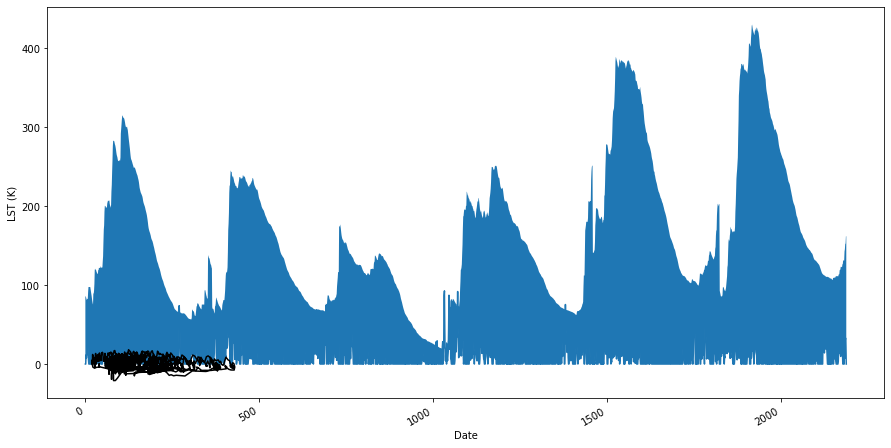

In [43]:
plt.rcParams['figure.figsize'] = (15,8)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Date')
ax1.set_ylabel('LST (K)')
ax1.plot(together.index, together['prec_data'], together['swe_data'], together['tmax_data'], 'k-')
ax1.fill_between(together.index, together['prec_data'], together['swe_data'], together['tmax_data'])
ax1.tick_params(axis='y')
fig.autofmt_xdate()


plt.show()

## MODIS TOWN

In [44]:
snow = pd.read_csv('data/MODIS/snow_cover.csv').set_index('date')
temp = pd.read_csv('data/MODIS/land_surface_temp_K.csv').set_index('date')

In [45]:
modis = pd.DataFrame()

In [49]:
modis['snow'] = snow['NDSI_Snow_Cover']
modis['temp'] = temp['LST_Day_1km']


<AxesSubplot:xlabel='date'>

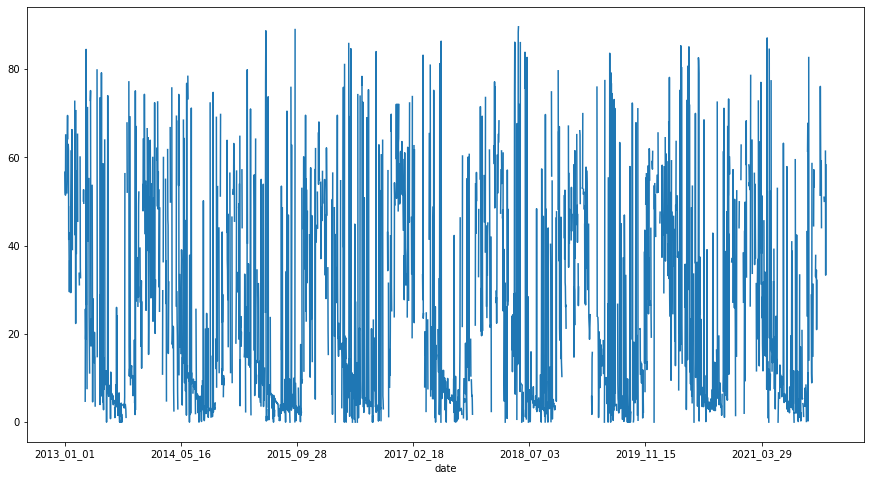

In [54]:
modis['snow'].plot()